## Problem Statement

In the insurance company, cross-selling is a crucial way to ensure the sustainability of the company. Although cross-selling is also important in other kind of businesses as well, it become so special in insurance due to risk sharing principle as each customer need to pay a premium of certain number to cover other customer risk that valued far higher than the premium itself. If the company can collect customer as much as possible, the company will grow really fast.

However, cross-selling attempts need to be performed as percise as possible. If we take a wrong step to outreach a customer, the worst scenario is the customer will not only reject our offering to the other product, but he/she possibly will cancel the purchasing of original transaction as well. This task will show data science practice to predict potential customer to buy a health insurance product from all customers who already bought a vehicle insurance product

Not only that, most of machine learning algorithms have `.predict_proba()` feature that can return a probability of a prediction. This feature can deliver an insight to the marketing team, so that they can plan the strategy to outreach a customer. As the probability to predict 1 (potential customer) class si getting higher, the marketing can take a more persuasive way to outreach these kind of customer, e.g. conduct a personal meeting.

## Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import pingouin as pg
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline

from feature_engine.categorical_encoders import RareLabelCategoricalEncoder

import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


## Load Data

In [2]:
df = pd.read_csv('archive/train.csv')

## Exploratory Data Analysis

In [3]:
# Function to describe data
def desc_data(df):
    dataDesc = []

    for i in df.columns:
        dataDesc.append([
            i,
            df[i].dtypes,
            df[i].isna().sum(),
            round((df[i].isna().sum() / len(df)) * 100, 2),
            df[i].nunique(),
            df[i].drop_duplicates().sample(2).values
        ])

    dataDesc = pd.DataFrame(dataDesc, columns=[
        'Data Features',
        'Data Types',
        'Null',
        'Null Percentage',
        'Unique',
        'Unique Sample'
    ])
    
    return dataDesc

In [4]:
desc_data(df)

,Data Features,Data Types,Null,Null Percentage,Unique,Unique Sample
0,id,int64,0,0.0,381109,"[377072, 335080]"
1,Gender,object,0,0.0,2,"[Female, Male]"
2,Age,int64,0,0.0,66,"[24, 55]"
3,Driving_License,int64,0,0.0,2,"[1, 0]"
4,Region_Code,float64,0,0.0,53,"[42.0, 35.0]"
5,Previously_Insured,int64,0,0.0,2,"[0, 1]"
6,Vehicle_Age,object,0,0.0,3,"[> 2 Years, < 1 Year]"
7,Vehicle_Damage,object,0,0.0,2,"[No, Yes]"
8,Annual_Premium,float64,0,0.0,48838,"[46945.0, 67560.0]"
9,Policy_Sales_Channel,float64,0,0.0,155,"[103.0, 158.0]"


Our data contains 10 feature to predict 1 target (`Response`). From the description above, we could se our data **does not contain any missing values**.

In [5]:
df['Response'] = df['Response'].apply(str)

> ### Variable description

**1. `id`**

The `id` column contains unique information about customer id registered in the company's database

In [6]:
df['id'].shape, df.shape

((381109,), (381109, 12))

This column will not deliver any contribution to the prediction model itself so we have to remove it later on the modelling section

**2. `Gender`**

This column gives information about gender of the customer

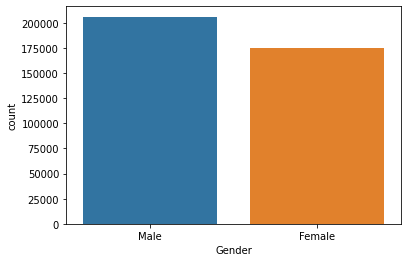

In [7]:
sns.countplot(x='Gender', data=df);

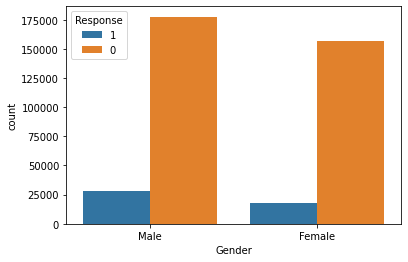

In [8]:
sns.countplot(x='Gender', hue='Response', data=df);

In [9]:
(pd.crosstab(index=df['Gender'], columns=df['Response'], normalize=True)*100).round(2)

Response,0,1
Gender,,
Female,41.15,4.77
Male,46.59,7.48


There is no sign that `Gender` can gives good separation to our target.

**3.` Age`** 

This column gives information about our customers' age.

In [10]:
df['Age'].describe()

count    381109.000000
mean         38.822584
std          15.511611
min          20.000000
25%          25.000000
50%          36.000000
75%          49.000000
max          85.000000
Name: Age, dtype: float64

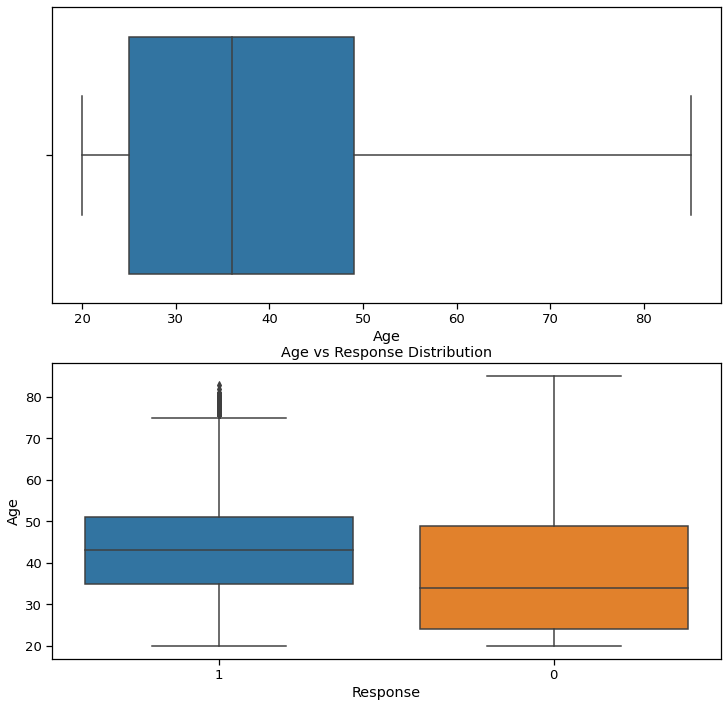

In [11]:
plt.figure(figsize=(12,12))
sns.set_context(context='notebook', font_scale=1.2)

plt.subplot(211)
sns.boxplot(data=df, x='Age')

plt.subplot(212)
sns.boxplot(data=df, y="Age", x="Response")
plt.title('Age vs Response Distribution');

Our customer age is ranging from 20's to 80's with the central value around 36 to 38. The potential customer have median age around 43 years old, while non-potential customer have lower median age (around 35 years old).

Although the univariate box plot can not detect any outliers, this variable seems not follow normal distribution. To ensure this claim, we can do normality test:

<Figure size 720x720 with 0 Axes>

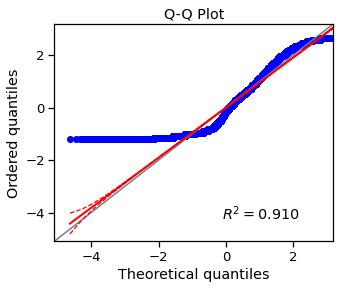

In [12]:
plt.figure(figsize=(10,10))
pg.qqplot(df['Age'], dist='norm');

In [13]:
normal, p = stats.normaltest(df['Age'])
# h0: X comes from normal distribution
# h1: X does not come from normal distribution
if p < 0.05:
    print('Age does not follow normal distribution')
else:
    print('Age does not follow normal distribution')

Age does not follow normal distribution


**4. `Driving License`** 

In [14]:
df['Driving_License'].value_counts()

1    380297
0       812
Name: Driving_License, dtype: int64

In [15]:
(pd.crosstab(index=df['Driving_License'], columns=df['Response'], normalize=True)*100).round(2)

Response,0,1
Driving_License,,
0,0.20,0.01
1,87.54,12.25


Most of our customer have driving license. This fact is make sense since our customer age is started from 20's. It is also hard to tell wether this feature is a good predictor to predict our target

**5. `Region Code`**

This column gives information about unique code of the customer region

In [16]:
df['Region_Code']

0         28.0
1          3.0
2         28.0
3         11.0
4         41.0
          ... 
381104    26.0
381105    37.0
381106    30.0
381107    14.0
381108    29.0
Name: Region_Code, Length: 381109, dtype: float64

The representation of this variable should be in the form of categorical data (`dtype: object`). We can do this manually

In [17]:
df['Region_Code'] = df['Region_Code'].apply(str)

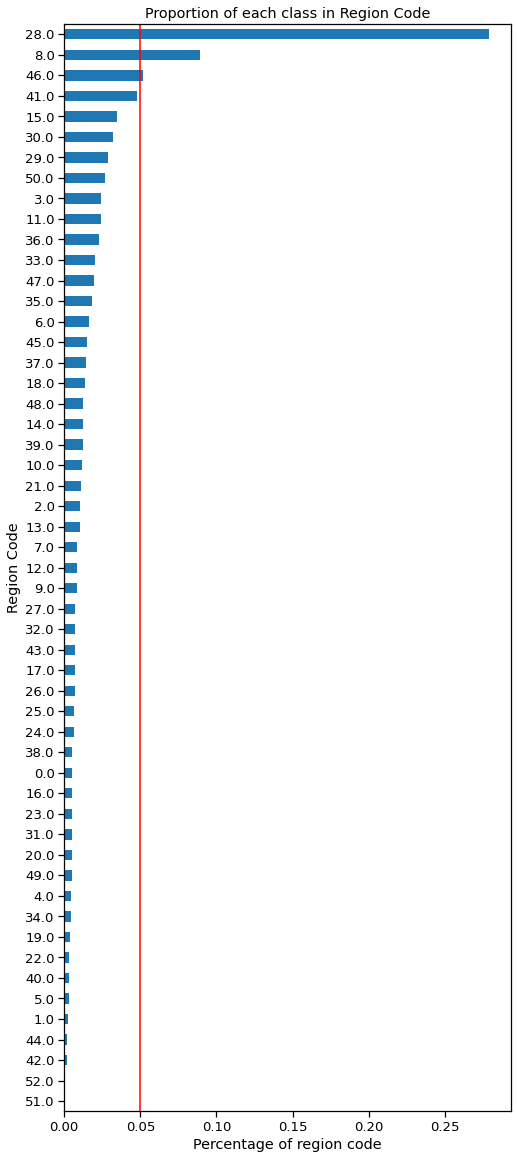

In [18]:
temp_df = pd.Series(df['Region_Code'].value_counts() / len(df) )

# make plot with the above percentages
plt.figure(figsize=(8,20))
fig = temp_df.sort_values().plot.barh()
fig.set_ylabel('Region Code')

# add a line at 5 % to flag the threshold for rare categories
fig.axvline(x=0.05, color='red')
fig.set_xlabel('Percentage of region code')
plt.title('Proportion of each class in Region Code')
plt.show()

There are so many rare classes. By using threshold value of 0.05, there are only 3 classes that are not rare. This phenomenon is called high cardinality. Highly cardinal feature is having difficulties to peform as a predictor. To handle this, we can do rare labels encoding using Feature-Engine library

In [19]:
rare_encoder = RareLabelCategoricalEncoder(
    tol = 0.05,  # minimal percentage to be considered non-rare
    n_categories = 4, # minimal number of categories the variable should have to re-cgroup rare categories
    variables = ['Region_Code'] # variables to re-group
)  

rare_encoder.fit(df)

# the encoder_dict_ is a dictionary of variable: frequent labels pair
rare_encoder.encoder_dict_

{'Region_Code': Index(['28.0', '8.0', '46.0'], dtype='object')}

In [20]:
df_rare_encoded = rare_encoder.transform(df)
df_rare_encoded['Region_Code'].value_counts()

Rare    221068
28.0    106415
8.0      33877
46.0     19749
Name: Region_Code, dtype: int64

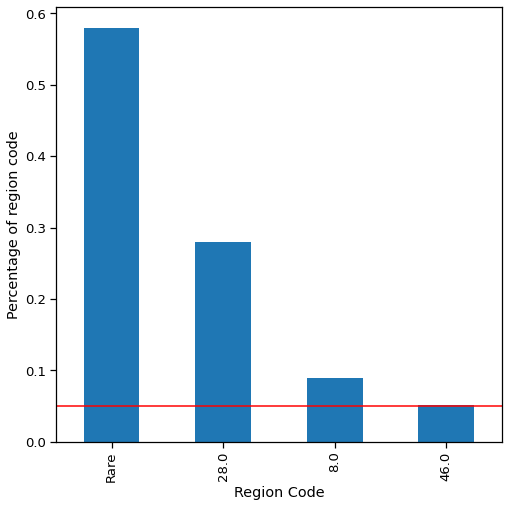

In [21]:
temp_df = pd.Series(df_rare_encoded['Region_Code'].value_counts() / len(df_rare_encoded))

# make plot with the above percentages
plt.figure(figsize=(8,8))
fig = temp_df.sort_values(ascending=False).plot.bar()
fig.set_xlabel('Region Code')

# add a line at 5 % to flag the threshold for rare categories
fig.axhline(y=0.05, color='red')
fig.set_ylabel('Percentage of region code')
plt.show()

In [22]:
(pd.crosstab(index=df_rare_encoded['Region_Code'], columns=df_rare_encoded['Response'], normalize=True)*100).round(2)

Response,0,1
Region_Code,,
28.0,22.70,5.23
46.0,4.65,0.53
8.0,8.03,0.85
Rare,52.36,5.64


After doing rare label encoding, the `Region_Code` now have 4 classes with the rare category now being the majority class. I couldn't say this approach will bring good impact to the model performance or not. However, a small insight we can get is: The 28.0 and rare classes share quite similar proportion for potential customers, while in the not potential customers, the proportion of 28.0 is less than half of the rare class proportion.

**6. `Previously Insured`**

This variable tells us whether the customer is already has a vehicle insurance (1) or not (0).

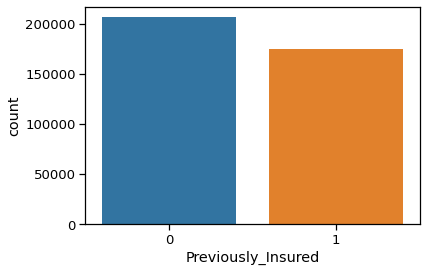

In [23]:
sns.countplot(x='Previously_Insured', data=df);

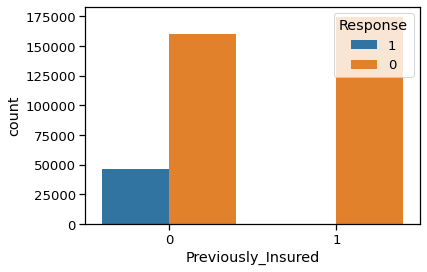

In [24]:
sns.countplot(x='Previously_Insured', hue='Response',data=df);

In [25]:
(pd.crosstab(index=df_rare_encoded['Previously_Insured'], columns=df_rare_encoded['Response'], normalize=True)*100).round(2)

Response,0,1
Previously_Insured,,
0,41.96,12.21
1,45.78,0.04


The proportion of our customer who already secured a vehicle insurance is slightly lower than the one who does not secured one. In relation to the target, there are almost no customer who already secure a vehicle insurance will accept our offer. Although the pattern is not clear enough, this variable might be the best predictor of our target compared to the others.

**7. `Vehicle Age`**

Vehicle age column represent the age of customer owned vehicle

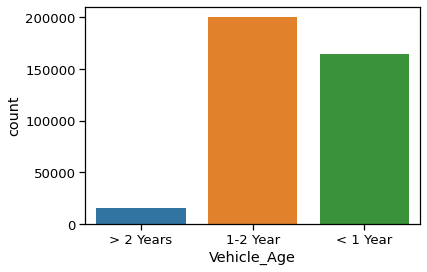

In [26]:
sns.countplot(x='Vehicle_Age', data=df);

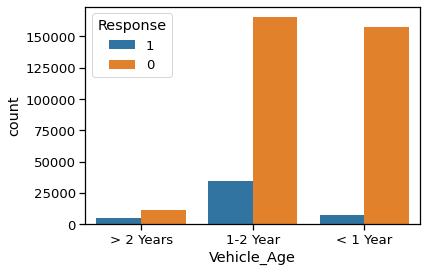

In [27]:
sns.countplot(x='Vehicle_Age', hue='Response',data=df);

In [28]:
(pd.crosstab(index=df_rare_encoded['Vehicle_Age'], columns=df_rare_encoded['Response'], normalize=True)*100).round(2)

Response,0,1
Vehicle_Age,,
1-2 Year,43.43,9.13
< 1 Year,41.35,1.89
> 2 Years,2.97,1.23


Most of our customer own quite new vehicle. However, the proportion of the potential customers who have more than 2 years old vehicle is higher than the proportion of the non potential customers who have more than 2 years old vehicle.

**8. `Vehicle_Damage`**

This feature tells us whether the customers' vehicle is damaged or not

In [29]:
df['Vehicle_Damage'].value_counts()

Yes    192413
No     188696
Name: Vehicle_Damage, dtype: int64

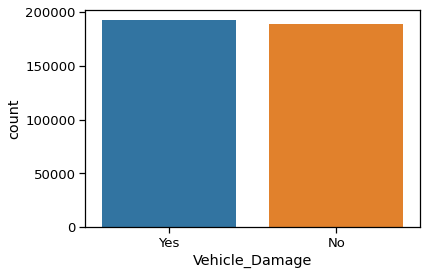

In [30]:
sns.countplot(x='Vehicle_Damage', data=df);

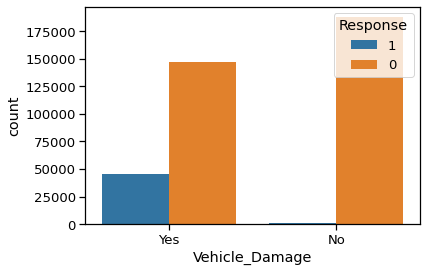

In [31]:
sns.countplot(x='Vehicle_Damage', hue='Response',data=df);

In [32]:
(pd.crosstab(index=df_rare_encoded['Vehicle_Damage'], columns=df_rare_encoded['Response'], normalize=True)*100).round(2)

Response,0,1
Vehicle_Damage,,
No,49.25,0.26
Yes,38.49,12.00


The proportion of damaged and not damaged vehicle in our customers is quite similar. However, the customer with damaged vehicle will mostly accept our cross-selling offers.

**9. `Annual Premium`**

This variable shows how many premium paid by each customer per year

In [33]:
df['Annual_Premium'].describe()

count    381109.000000
mean      30564.389581
std       17213.155057
min        2630.000000
25%       24405.000000
50%       31669.000000
75%       39400.000000
max      540165.000000
Name: Annual_Premium, dtype: float64

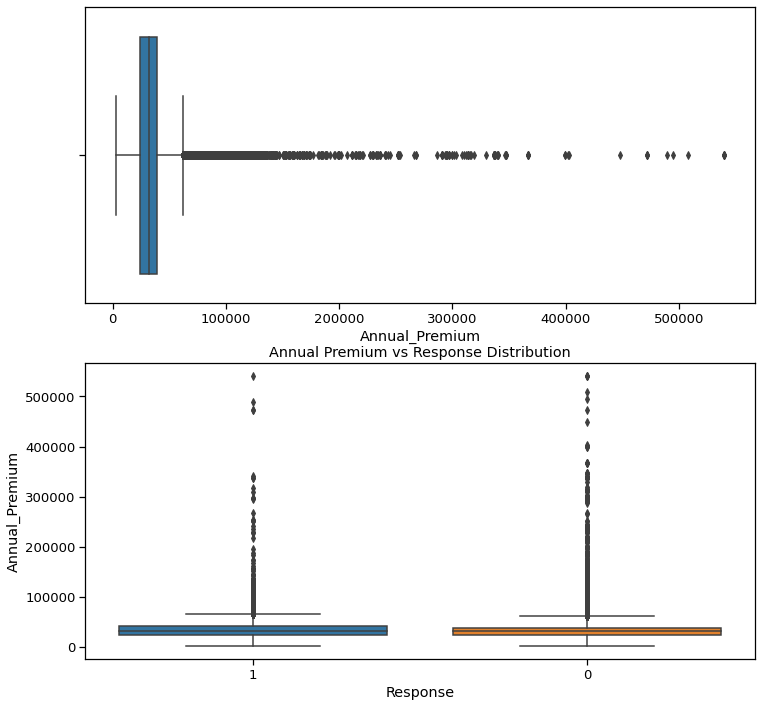

In [34]:
plt.figure(figsize=(12,12))
# sns.set_context(context='notebook', font_scale=1.5)

plt.subplot(211)
sns.boxplot(data=df, x='Annual_Premium')

plt.subplot(212)
sns.boxplot(data=df, y="Annual_Premium", x="Response")
plt.title('Annual Premium vs Response Distribution');

The `Annual_Premiun` variable contains some outliers. In the preprocessing section, we can try to detect and remove the outliers and see how this approach would affect the model performance.

In [35]:
filtered_entries = np.array([True] * len(df))

col = 'Annual_Premium'
Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3 - Q1
low_limit = Q1 - (IQR * 1.5)
high_limit = Q3 + (IQR * 1.5)

filtered_entries = ((df[col] >= low_limit) & (df[col] <= high_limit)) & filtered_entries

In [36]:
df_no_out = df[filtered_entries]

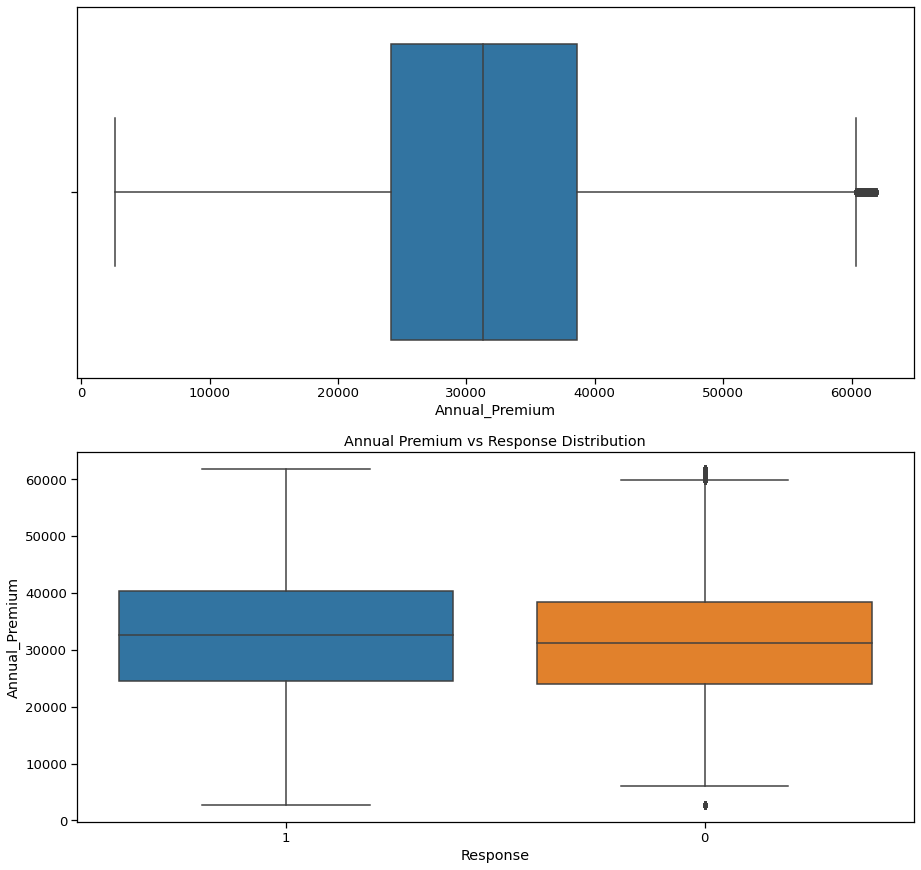

In [37]:
plt.figure(figsize=(15,15))
# sns.set_context(context='notebook', font_scale=1.5)

plt.subplot(211)
sns.boxplot(data=df_no_out, x='Annual_Premium')

plt.subplot(212)
sns.boxplot(data=df_no_out, y="Annual_Premium", x="Response")
plt.title('Annual Premium vs Response Distribution');

In [38]:
df_no_out[df_no_out['Annual_Premium'] < 10000]['Annual_Premium'].describe()

count    64882.000000
mean      2630.446426
std         52.329471
min       2630.000000
25%       2630.000000
50%       2630.000000
75%       2630.000000
max       9816.000000
Name: Annual_Premium, dtype: float64

After removing the outlier with +- 1.5IQR rule, we can see that the strange data below Rs10000 are still there. It seems this data is not correlated that much to our target since the groupped median by `Response` are just slightly different  

**10. `Policy Sales Channel`**

This feature is representing anonymized code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.

In [39]:
df['Policy_Sales_Channel'].describe()

count    381109.000000
mean        112.034295
std          54.203995
min           1.000000
25%          29.000000
50%         133.000000
75%         152.000000
max         163.000000
Name: Policy_Sales_Channel, dtype: float64

Due to the nature of the data, this feature shoould be represented as a categorical variable. We can do it manually like `Region_Code` variable as well

In [40]:
df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].apply(str)

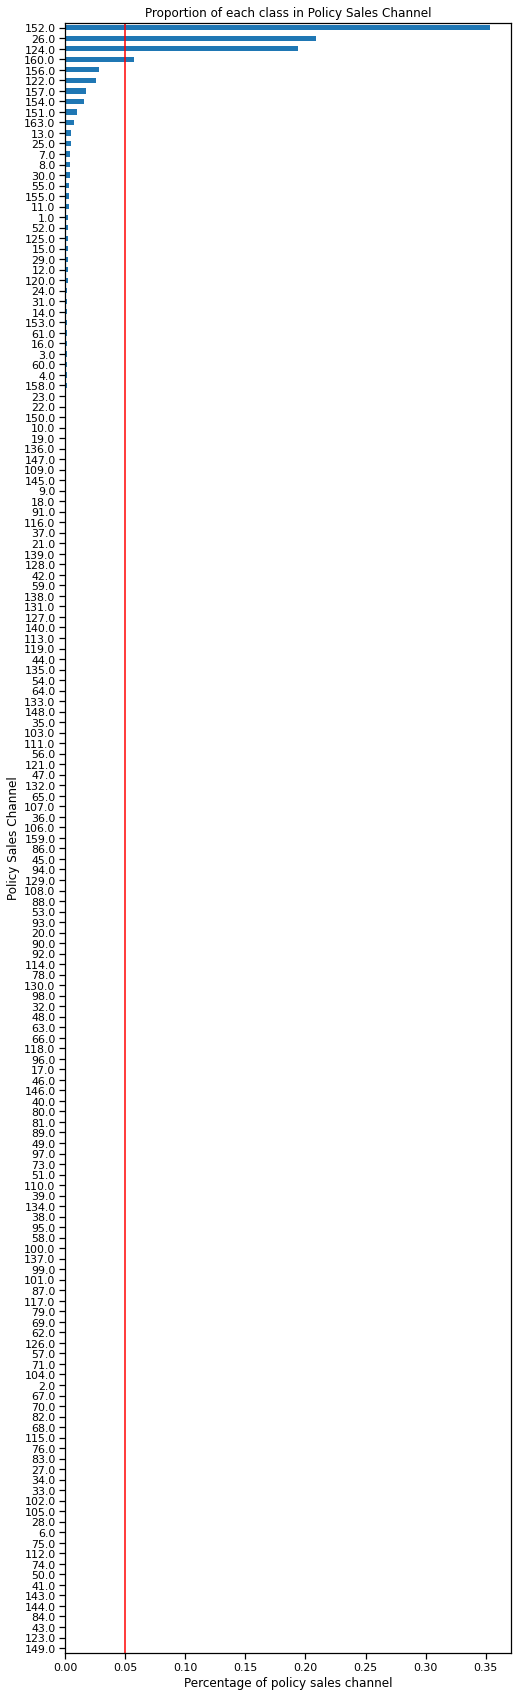

In [41]:
temp_df = pd.Series(df['Policy_Sales_Channel'].value_counts() / len(df) )

# make plot with the above percentages
plt.figure(figsize=(8,30))
sns.set_context(context='notebook', font_scale=1)
fig = temp_df.sort_values().plot.barh()
fig.set_ylabel('Policy Sales Channel')

# add a line at 5 % to flag the threshold for rare categories
fig.axvline(x=0.05, color='red')
fig.set_xlabel('Percentage of policy sales channel')
plt.title('Proportion of each class in Policy Sales Channel')
plt.show()

This variable contains many rare class. By using threshold value of 0.05, we can see that only 4 classes contains non-rare labels. Again, to handle this, we can use RareLabelsEncoder provided by Feature Engine library.

In [42]:
rare_encoder = RareLabelCategoricalEncoder(
    tol = 0.05,  # minimal percentage to be considered non-rare
    n_categories = 4, # minimal number of categories the variable should have to re-cgroup rare categories
    variables = ['Policy_Sales_Channel'] # variables to re-group
)  

rare_encoder.fit(df)

# the encoder_dict_ is a dictionary of variable: frequent labels pair
rare_encoder.encoder_dict_

{'Policy_Sales_Channel': Index(['152.0', '26.0', '124.0', '160.0'], dtype='object')}

In [43]:
df_rare_encoded = rare_encoder.transform(df)
df_rare_encoded['Policy_Sales_Channel'].value_counts()

152.0    134784
26.0      79700
124.0     73995
Rare      70851
160.0     21779
Name: Policy_Sales_Channel, dtype: int64

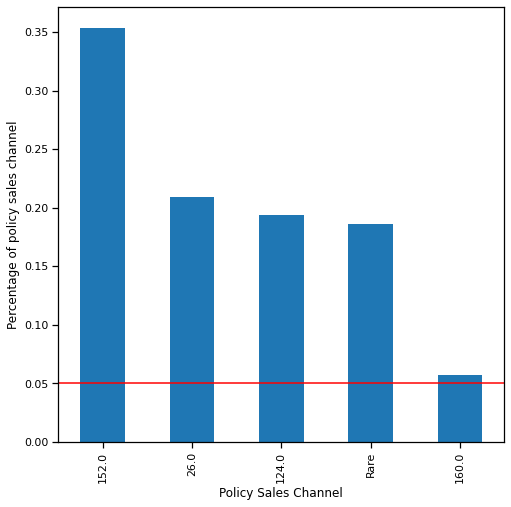

In [44]:
temp_df = pd.Series(df_rare_encoded['Policy_Sales_Channel'].value_counts() / len(df_rare_encoded))

# make plot with the above percentages
plt.figure(figsize=(8,8))
fig = temp_df.sort_values(ascending=False).plot.bar()
fig.set_xlabel('Policy Sales Channel')

# add a line at 5 % to flag the threshold for rare categories
fig.axhline(y=0.05, color='red')
fig.set_ylabel('Percentage of policy sales channel')
plt.show()

In [45]:
(pd.crosstab(index=df_rare_encoded['Policy_Sales_Channel'], columns=df_rare_encoded['Response'], normalize=True)*100).round(2)

Response,0,1
Policy_Sales_Channel,,
124.0,15.74,3.67
152.0,34.35,1.01
160.0,5.59,0.12
26.0,16.74,4.17
Rare,15.31,3.28


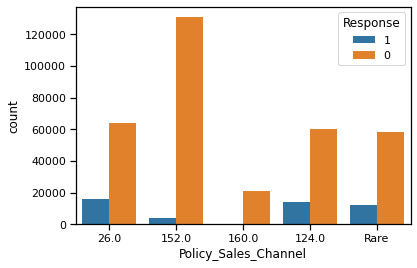

In [46]:
sns.countplot(x='Policy_Sales_Channel', hue='Response', data=df_rare_encoded);

After doing rare labels encoding, this feature return 5 classes including the `rare` class. In this feature, the proportion of 26.0 class is the highest among all other classes. 

**11. `Vintage`**

This feature tells us how long (in days) each customer has been associated with our company

In [47]:
df['Vintage'].describe()

count    381109.000000
mean        154.347397
std          83.671304
min          10.000000
25%          82.000000
50%         154.000000
75%         227.000000
max         299.000000
Name: Vintage, dtype: float64

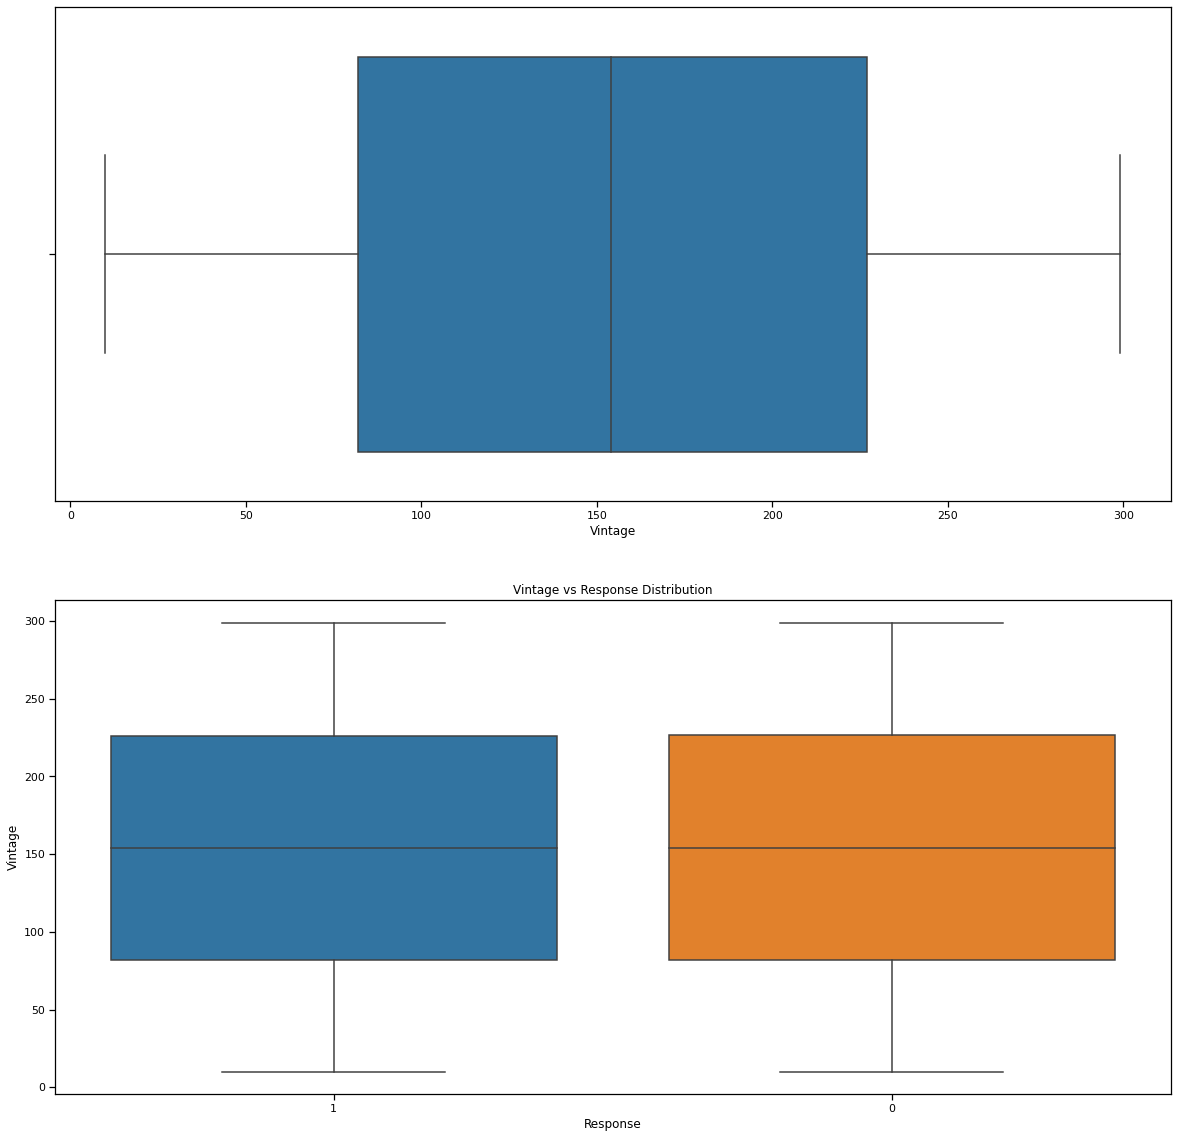

In [48]:
plt.figure(figsize=(20,20))
# sns.set_context(context='notebook', font_scale=2)

plt.subplot(211)
sns.boxplot(data=df, x='Vintage')

plt.subplot(212)
sns.boxplot(data=df, y="Vintage", x="Response")
plt.title('Vintage vs Response Distribution');

The distribution of this variable looks fairly equal for each unique data. In relation to our target, this variable might not be a good predictor to classify potential and non-potential customer

> ### Target Distribution

In [49]:
df['Response'].value_counts(normalize=True)

0    0.877437
1    0.122563
Name: Response, dtype: float64

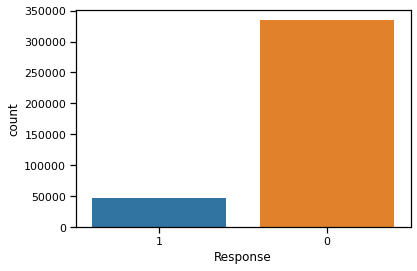

In [50]:
sns.countplot(x='Response', data=df);

The target distribution is highly imbalance. This is an indication that we should use resampling techniques in the preprocessing section